In [11]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sn

from gene_variation_effects import config
from gene_variation_effects.modeling import NNPipeLine, MLP, data_shuffle_split, run_training_loop, test_model

seed = 42
TARGET_GENE = "BRCA1"
df = None

In [12]:
DATASET_NAME = 'BRCA1_dataset.csv'
TARGET_FEATURE = 'ClinSigSimple'
df = pd.read_csv(os.path.join(config.DATA_DIR, DATASET_NAME))


In [13]:
if df is None:
    df = pd.read_csv(os.path.join(config.DATA_DIR, f"{TARGET_GENE}.csv"))

target_array = df[TARGET_FEATURE]
df.drop(columns=[TARGET_FEATURE], inplace=True)
ONEHOT_FEATURES = ['Type']
EMBEDDED_FEATURES = []
NUMERIC_FEATURES = ['VariantLength', 'VariantLengthDifference', 'RelativeStart', "PhyloScore", "ConservationDisruption", "DistanceFromEnd", "OriginGermline"]
pipeline = NNPipeLine(df.columns, ONEHOT_FEATURES, EMBEDDED_FEATURES, NUMERIC_FEATURES)

In [14]:
# Split the data
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.3
training_data, validation_data, test_data, training_target_array, validation_target_array, test_target_array = \
    data_shuffle_split(df.to_numpy(), target_array, TEST_SIZE, VALIDATION_SIZE, seed)

In [15]:
# Fit pipeline and transform data
transformed_X_training, feature_processor = pipeline.fit_feature_transformations(training_data)
transformed_X_training = torch.Tensor(transformed_X_training)
transformed_X_validation = torch.Tensor(feature_processor.transform(validation_data))
transformed_X_test = torch.Tensor(feature_processor.transform(test_data))

training_target_array = torch.unsqueeze(torch.Tensor(training_target_array.to_numpy()), 1)
validation_target_array =  torch.unsqueeze(torch.Tensor(validation_target_array.to_numpy()), 1)
test_target_array =  torch.unsqueeze(torch.Tensor(test_target_array.to_numpy()), 1)

In [29]:
HIDDEN_SIZES = [256, 128, 64]
DROPOUT = 0
embedding_dimension_mapping = np.array([])
model = MLP(embedding_dimension_mapping, HIDDEN_SIZES, transformed_X_training.shape[1], DROPOUT)

2025-11-02 23:20:54.317 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 1: accuracy=0.5312
2025-11-02 23:20:54.317 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130 - Epoch 1: validation accuracy=0.4375
2025-11-02 23:20:54.317 | INFO     | gene_variation_effects.modeling.train:run_training_loop:131 - Epoch 1: validation loss=1.8335
2025-11-02 23:20:54.321 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 2: accuracy=0.5000
2025-11-02 23:20:54.321 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130 - Epoch 2: validation accuracy=0.4688
2025-11-02 23:20:54.321 | INFO     | gene_variation_effects.modeling.train:run_training_loop:131 - Epoch 2: validation loss=1.8315
2025-11-02 23:20:54.323 | INFO     | gene_variation_effects.modeling.train:run_training_loop:129 - Epoch 3: accuracy=0.6562
2025-11-02 23:20:54.323 | INFO     | gene_variation_effects.modeling.train:run_training_loop:130

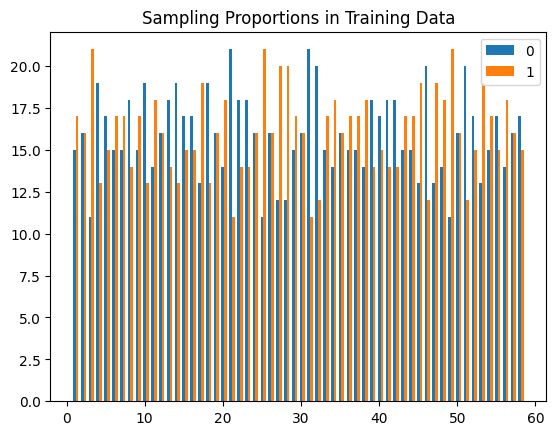

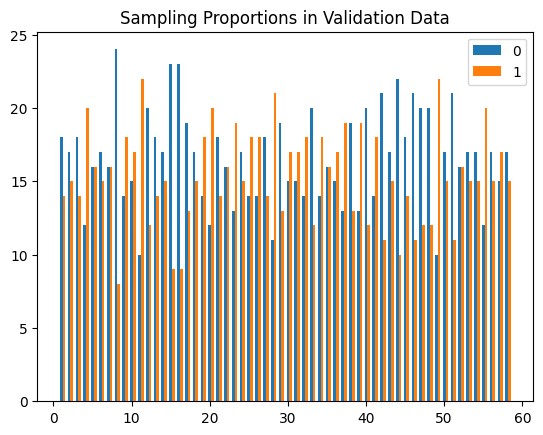

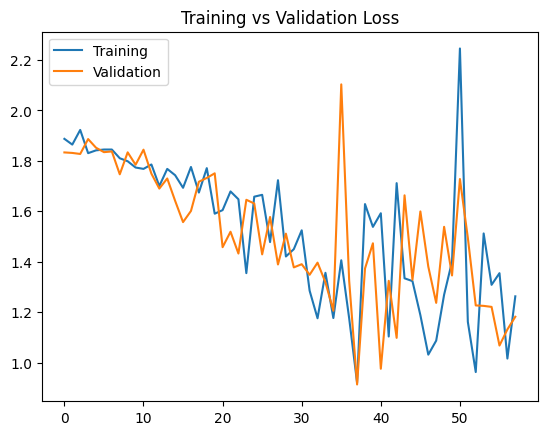

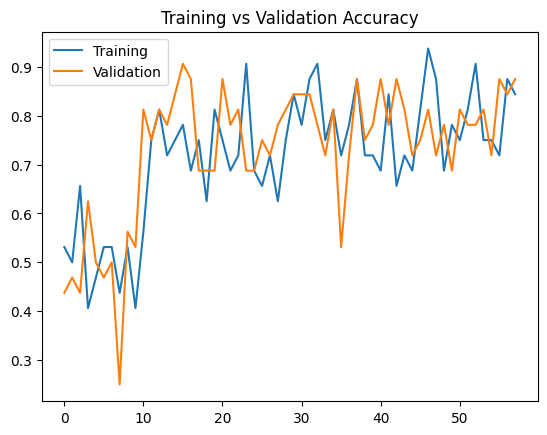

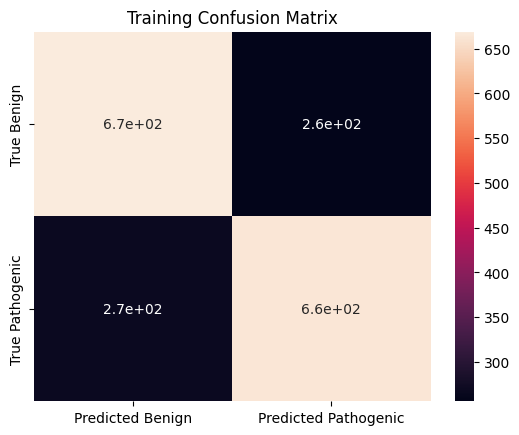

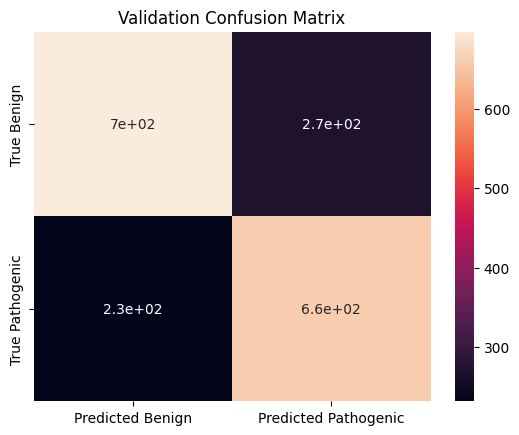

<Figure size 640x480 with 0 Axes>

In [30]:
# Get indices for columns using embedding
features_indices = {feat: i for i, feat in enumerate(feature_processor.get_feature_names_out())}
embedding_features_indices = [ind for feat, ind in features_indices.items() if feat.startswith('high_cardinality')]
BATCH_SIZE = 32
PATIENCE = 20
PREDICTION_THRESHOLD = 0.45

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimal_model_dict, training_losses, val_losses, training_accuracies, val_accuracies, training_confusion_matrix, val_confusion_matrix = run_training_loop(
    model, BATCH_SIZE, transformed_X_training, transformed_X_validation, training_target_array, validation_target_array, embedding_features_indices, patience=PATIENCE, 
    positive_threshold=PREDICTION_THRESHOLD,
    optimizer=optimizer)
torch.save(optimal_model_dict, f"../models/{TARGET_GENE}model.pth")


plt.plot(training_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(training_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
plt.clf()

cm_indices = ["True Benign", "True Pathogenic"]
cm_cols = ["Predicted Benign", "Predicted Pathogenic"]
training_confusion_matrix_df = pd.DataFrame(training_confusion_matrix, index = cm_indices, columns = cm_cols)
val_confusion_matrix_df = pd.DataFrame(val_confusion_matrix, index = cm_indices, columns = cm_cols)
# plt.matshow(training_confusion_matrix_df)
# plt.matshow(val_confusion_matrix_df)
sn.heatmap(training_confusion_matrix_df, annot=True)
plt.title("Training Confusion Matrix")
plt.show()
plt.clf()
sn.heatmap(val_confusion_matrix_df, annot=True)
plt.title("Validation Confusion Matrix")
plt.show()
plt.clf()

In [31]:
# Actual pathogenic variations out of the predicted pathogenic
precision = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df['Predicted Pathogenic'])
# Proportion of actual pathogenic variants which were predicted correctly
recall = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df.loc['True Pathogenic'])
# Proportion of actual benign which were predicted correctly
specificity = training_confusion_matrix_df['Predicted Benign']['True Benign'] / sum(training_confusion_matrix_df.loc['True Benign'])

print(precision)
print(recall)
print(specificity)

0.721436343852013
0.7121374865735768
0.7232432432432433


In [32]:
# Recreate the model structure
model.load_state_dict(torch.load(f"../models/{TARGET_GENE}model.pth"))

<All keys matched successfully>

In [33]:
avg_loss, accuracy = test_model(model, BATCH_SIZE, transformed_X_test, test_target_array, embedding_features_indices)
avg_loss, accuracy

(0.4658100062175653, tensor(0.8036))